In [ ]:
pip install networkx

In [106]:
import networkx as nx
import statistics
from networkx.readwrite.graphml import read_graphml
import copy
import matplotlib.pyplot as plt
import numpy as np

Загрузим граф:

https://github.com/Ivanlasich/visualisation_methods-/blob/main/graph.xml - ссылка на граф

## При наличествующем w реализуем распределение по слоям с помощью алгоритма Грэхема—Коффмана, который был описан на лекции, данная секция подразумевает то, что w задан: 


Зададим максимальную ширину w=3

In [107]:
w=3

In [108]:
def top_sort(start_nodes):
    queue = []
    for j in start_nodes:
        queue.append(j)
        visited[j] = 1
    index = 0
    while queue != []:
        new_queue = []
        while queue != []:
            i = queue.index(min(queue, key=lambda x: sorted(incom_nodes[x], key= lambda y:-y)))
            i = queue.pop(i)
            numbers[i] = index
            index += 1
            for node in edges[i]:
                ind = incom_nodes[node].index(np.inf)
                incom_nodes[node][ind] = numbers[i]
                if(np.inf in incom_nodes[node]):
                    continue
                else:
                    new_queue.append(node)
                    visited[node] = 1

        queue = new_queue

In [109]:
example = read_graphml('graph.xml')

In [110]:
nodes = [int(i[1:]) for i in list(example.nodes)]
edges={}
for node in list(example.nodes):
  edges[int(node[1:])]=[int(i[1:]) for i in example.neighbors(node)]


incom_nodes={node:[] for node in nodes}
visited = {node:0 for node in nodes}
numbers = {node:np.inf for node in nodes}

In [111]:
for j in nodes:
  if(visited[j]==1):
    continue
  queue=[]
  queue.append(j)
  while queue!=[]:
    i = queue.pop(0)
    visited[i] = 1
    for node in edges[i]:
      if(visited[node]==1):
          incom_nodes[node].append(numbers[i])
          continue
      visited[node] = 1
      queue.append(node)
      incom_nodes[node].append(numbers[i])


visited = {node:0 for node in nodes}
start_nodes=[node for node in nodes if incom_nodes[node]==[]]
first_layer = [node for node in nodes if edges[node]==[]]
index = 0
for i in start_nodes:
  numbers[i]=index
  index+=1

Пронумеруем вершины:

In [112]:
top_sort(start_nodes)

In [113]:
new_vertex=[(i,numbers[i]) for i in numbers]
new_vertex.sort(key= lambda x: -x[1])


In [114]:
def check_layer(vertex, num):
    check_for_layer = 1

    for edge in edges[vertex[0]]:
        if (num_layer[edge] == num):
            check_for_layer = 0
            break

    return check_for_layer


def check_visit(vertex):
    check_for_visit = 1

    for edge in edges[vertex[0]]:
        if (visited[edge] != 1):
            check_for_visit = 0
            break
    return check_for_visit


def distr_by_layer(w, queue):
    num = 0
    current = -1
    layer = [[]]
    while (queue != []):
        for j, element in enumerate(queue):
            check_for_visit = check_visit(element)
            if check_for_visit == 1:
                current = queue.pop(j)
                break
        check_for_layer = check_layer(current, num)
        if ((check_for_layer == 0) or (len(layer[num]) >= w)):
            num += 1
            layer.append([])
            layer[num].append(current[0])
            visited[current[0]] = 1
            num_layer[current[0]] = num
        else:
            layer[num].append(current[0])
            visited[current[0]] = 1
            num_layer[current[0]] = num
    return layer

In [115]:
visited = {node:0 for node in nodes}
num_layer = {node:-1 for node in nodes}
new_vertex=[(i,numbers[i]) for i in numbers]
new_vertex.sort(key= lambda x: -x[1])
queue = new_vertex
lay = distr_by_layer(w, queue)

## В данной секции кода содержится реализация алгоритм минимизации количества dummy-вершин, когда w не задано, код в этой секции нужно использовать если w не задано:


Если w не задано:

In [75]:
nodes = [int(i[1:]) for i in list(example.nodes)]
edges={}
for node in list(example.nodes):
  edges[int(node[1:])]=[int(i[1:]) for i in example.neighbors(node)]


incom_nodes={node:[] for node in nodes}
visited = {node:0 for node in nodes}
numbers = {node:np.inf for node in nodes}

In [76]:
from scipy.optimize import linprog

In [77]:
obj={node:0 for node in nodes}

for node in nodes:
  for edge in edges[node]:  
    if(edges[node]!=[]):
      obj[node]=obj[node]+1
      obj[edge]=obj[edge]-1

In [78]:
Obj = [obj[i] for i in obj]

In [79]:
lhs_ineq = []
rhs_ineq = []
for node in nodes:
  for edge in edges[node]:
    if(edges[node]!=[]):
      procc=[0 for i in range(len(nodes))]
      procc[node]=-1
      procc[edge]=1
      lhs_ineq.append(procc)
      rhs_ineq.append(-1)

In [80]:
bnd = [(0, max(nodes)) for i in range(len(nodes))]

In [81]:
opt = linprog(c=Obj, A_ub=lhs_ineq, b_ub=rhs_ineq,bounds=bnd)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [82]:
answ = opt.x

In [83]:
new_nodes = copy.deepcopy(nodes)
new_nodes.sort(key= lambda x: -answ[x])

In [84]:
new_ycoords={node:-1 for node in nodes}
for i in new_nodes:
  if(new_ycoords[i]==-1):
    central_y = round(answ[i])
    new_ycoords[i] = central_y 
    for edge in edges[i]:
      currenr_y = round(answ[edge])
      if(central_y == currenr_y):
        currenr_y = currenr_y-1
      new_ycoords[edge] = currenr_y 


In [85]:
const = min(new_ycoords.values())
for i in new_ycoords:
  new_ycoords[i]-=const

In [86]:
layer = [[] for i in range(max(new_ycoords.values())+1)]

In [87]:
for y in new_ycoords:
  layer[new_ycoords[y]].append(y)

In [88]:
lay=layer

## В секции ниже реализован алгоритм минимизации (эвристическими средствами) количества пересечений рёбер, идущих между соседними слоями:


In [116]:
x_coord={}
y_coord={}

In [117]:
y=0
pop=0
for vert in lay:
  x=0
  vert = vert
  for i in vert:
    x_coord[i]=x
    y_coord[i]=y
    x+=1
  y+=1

Отобразим промежуточные результаты, распределение вершин по слоям:

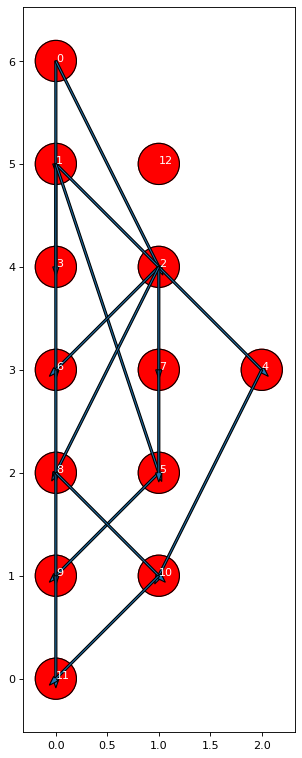

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')

ax=plt.gca()

for edge in edges:
  if (edges[edge]):
    for ex in edges[edge]:
      ax.arrow(x_coord[edge],y_coord[edge],-x_coord[edge]+x_coord[ex],-y_coord[edge]+y_coord[ex], width = 0.02)

for x,y in zip(x_coord, y_coord):
  circle = plt.Circle((x_coord[x], y_coord[y]), 0.2, color='r')
  ax.add_patch(circle)

for x,y in zip(x_coord, y_coord):
  circle = plt.Circle((x_coord[x], y_coord[y]), 0.2, color='black', fill=False)
  ax.add_patch(circle)
  ax.text(x_coord[x], y_coord[y], x, color='white')


plt.axis('scaled')
plt.show()

Добавим dummy вершины:

In [119]:
lay_reversed = lay[::-1]

In [120]:
maximum = max(nodes)
maximum+=1

In [121]:
super_edge = copy.deepcopy(edges)
edges = copy.deepcopy(super_edge)

In [122]:
dummy_vertex=[]
normal_vertex=super_edge.keys()

In [123]:
new_vertex={}
num=-1
for i in range(len(lay_reversed)):
  for ver in lay_reversed[i]:
    for edge in super_edge[ver]:
      if edge not in lay_reversed[i+1]:
        if (x_coord[ver]!=x_coord[edge]):
          a = (y_coord[ver]-y_coord[edge])/(x_coord[ver]-x_coord[edge])
          b = y_coord[ver] - a*x_coord[ver]
          iter = int(y_coord[ver]-y_coord[edge])
          ex=ver
          for j in range(iter):
            new_x = ((y_coord[ver]-1-j) - b)/a  
            if j==iter-1:
              edges[ver].pop(edges[ver].index(edge))
              try:
                 new_vertex[ex].append((edge,new_x,y_coord[ver]-1-j))
              except KeyError:
                 new_vertex[ex] = [(edge,new_x,y_coord[ver]-1-j)]
            else:
              try:
                 new_vertex[ex].append((maximum, new_x, y_coord[ver]-1-j))
              except KeyError:
                 new_vertex[ex] = [(maximum, new_x, y_coord[ver]-1-j)]
              dummy_vertex.append(maximum)
              ex=maximum
              maximum+=1
            
        if(x_coord[ver] == x_coord[edge]):
            iter = int(y_coord[ver]-y_coord[edge])
            ex = ver
            for j in range(iter):
              new_x = x_coord[ver]
              if j==iter-1:
                edges[ver].pop(edges[ver].index(edge))
                try:
                  new_vertex[ex].append((edge,new_x,y_coord[ver]-1-j))
                except KeyError:
                  new_vertex[ex] = [(edge,new_x,y_coord[ver]-1-j)]
              else:
                try:
                  new_vertex[ex].append((maximum,new_x,y_coord[ver]-1-j))
                except KeyError:
                  new_vertex[ex] = [(maximum,new_x,y_coord[ver]-1-j)]
                dummy_vertex.append(maximum)
                ex=maximum
                maximum+=1
          

In [124]:
x_coord_=copy.deepcopy(x_coord)
y_coord_=copy.deepcopy(y_coord)
edges_=copy.deepcopy(edges)

In [125]:
for i in new_vertex:
  for j in new_vertex[i]:
    if j[0] not in edges_:
      edges_[j[0]]=[]
      x_coord_[j[0]]=j[1]
      y_coord_[j[0]]=j[2]

for i in new_vertex:
  for j in new_vertex[i]:
      edges_[i].append(j[0])

минимизируем количество пересечений рёбер, идущих между соседними слоями: 

In [126]:
new_layer = [[] for i in range(len(lay))]
for y in y_coord_:
  new_layer[y_coord_[y]].append(y)

In [127]:
index=max(x_coord_.values())+1
for arr in new_layer:
  arr.sort(key=lambda x: x_coord_[x])

In [128]:
for arr in new_layer:
  if len(arr) >= index:
    p = index/len(arr)
    x_0=0
    for x in arr:
      x_coord_[x]=x_0
      x_0+=p

Отобразим ациклических орграф c добавленными dummy вершинами: 

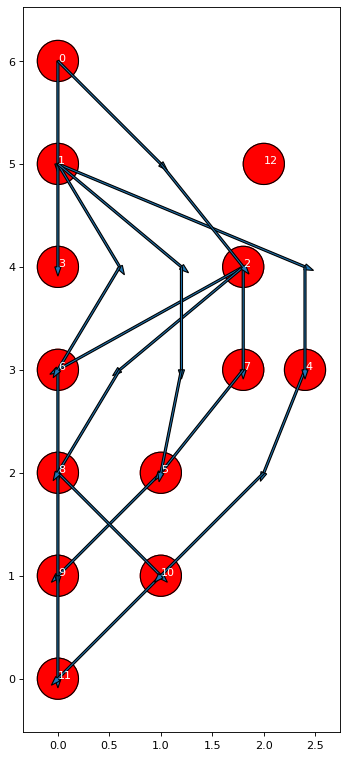

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')

ax=plt.gca()


for x,y in zip(x_coord_, y_coord_):
  if(x in normal_vertex):
    circle = plt.Circle((x_coord_[x], y_coord_[y]), 0.2, color='r')
    ax.add_patch(circle)
    circle = plt.Circle((x_coord_[x], y_coord_[y]), 0.2, color='black', fill=False)
    ax.add_patch(circle)
    ax.text(x_coord_[x], y_coord_[y], x, color='white')
  else:
    circle = plt.Circle((x_coord_[x], y_coord_[y]), 0.005, color='black')
    ax.add_patch(circle)
    
  #ax.add_patch(txt)
for edge in edges_:
  if (edges_[edge]):
    for ex in edges_[edge]:
      ax.arrow(x_coord_[edge],y_coord_[edge],-x_coord_[edge]+x_coord_[ex],-y_coord_[edge]+y_coord_[ex], width = 0.02)


plt.axis('scaled')
plt.show()

Минимизируем количество пересечений рёбер, идущих между соседними слоями используя эвристический алгоритм:

In [130]:
import itertools


def area(a_x, a_y, b_x, b_y, c_x, c_y): 
	return ((b_x - a_x) * (c_y - a_y) - (b_y - a_y) * (c_x - a_x))

def intersect_1(a,b,c,d):
  if (a>b):
    a,b=b,a
  if(c>d):
    c,d=d,c
  return (max(a,c)<=min(b,d))

def inder(x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4):
  if (((x_1 == x_3) and (y_1==y_3)) or ((x_2 == x_4) and (y_2==y_4))):
    return 0
  return int((intersect_1(x_1, x_2, x_3, x_4)) and (intersect_1(y_1, y_2, y_3, y_4)) and (area(x_1,y_1,x_2,y_2,x_3,y_3) * area(x_1,y_1,x_2,y_2,x_4,y_4) <= 0) and (area(x_3,y_3,x_4,y_4,x_1,y_1) * area(x_3,y_3,x_4,y_4,x_2,y_2) <= 0))
    
def euristiks(new_layer, x_coord):
    for i in range(len(new_layer) - 2):
        etalon = copy.deepcopy(x_coord)
        reverse = len(new_layer[i+1])
        count_min = countInderect(i, new_layer, x_coord)
        #по всем перестановкам, ограничим возможное количество перестановок т.к. иначе алгоритм будет работать долго 
        for permutation in itertools.permutations(range(min(6, reverse))):
            x_coord__ = copy.deepcopy(x_coord)
            #замена координат
            for j, k in enumerate(permutation):
                x_coord__[new_layer[i+1][int(k)]] = x_coord[new_layer[i+1][j]]
            count = countInderect(i, new_layer, x_coord__)
            if count < count_min:
                count_min = count
                etalon = copy.deepcopy(x_coord__)
        #присваиваем лучшие координаты:
        x_coord=copy.deepcopy(etalon)
    return x_coord

def countInderect(i, new_layer, x_coord_):
    count=0    
    coords = []
    for ver in new_layer[i]:
      for edge in edges_[ver]:
        coords.append([x_coord_[ver], y_coord_[ver], x_coord_[edge], y_coord_[edge]])
    
    for j in range(len(coords)):
      for k in range(j+1, len(coords)):
        count+=inder(coords[j][0],coords[j][1],coords[j][2],coords[j][3],coords[k][0],coords[k][1],coords[k][2],coords[k][3])

    coords = []
    for ver in new_layer[i+1]:
      for edge in edges_[ver]:
        coords.append([x_coord_[ver], y_coord_[ver], x_coord_[edge], y_coord_[edge]])
    for j in range(len(coords)):
      for k in range(j+1, len(coords)):
        count+=inder(coords[j][0],coords[j][1],coords[j][2],coords[j][3],coords[k][0],coords[k][1],coords[k][2],coords[k][3])
    
    return count

In [131]:
x_coord_ = euristiks(new_layer[::-1], x_coord_)

Отобразим окончательный результат:

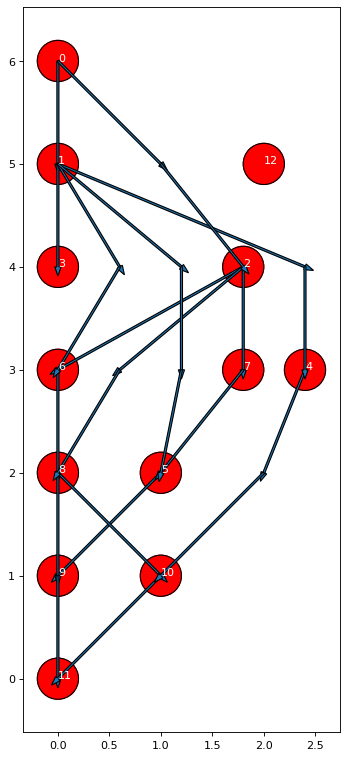

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')

ax=plt.gca()


for x,y in zip(x_coord_, y_coord_):
  if(x in normal_vertex):
    circle = plt.Circle((x_coord_[x], y_coord_[y]), 0.2, color='r')
    ax.add_patch(circle)
    circle = plt.Circle((x_coord_[x], y_coord_[y]), 0.2, color='black', fill=False)
    ax.add_patch(circle)
    ax.text(x_coord_[x], y_coord_[y], x, color='white')
  else:
    circle = plt.Circle((x_coord_[x], y_coord_[y]), 0.01, color='black')
    ax.add_patch(circle)

  #ax.add_patch(txt)
for edge in edges_:
  if (edges_[edge]):
    for ex in edges_[edge]:
      ax.arrow(x_coord_[edge],y_coord_[edge],-x_coord_[edge]+x_coord_[ex],-y_coord_[edge]+y_coord_[ex], width = 0.02)


plt.axis('scaled')
plt.show()